In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow,imread
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
import tensorflow as tf
import os


In [2]:
train_df = pd.read_csv('dataset/RSNA_Annotations/RSNA_Annotations/BONEAGE/boneage_train.csv')
train_df ['ID'] = train_df['ID'].map(lambda x: f'{x}.png')
train_df['Male']= train_df['Male'].map(lambda x: 1 if (x == True) else 0)
train_df

,ID,Male,Boneage
0,1377.png,0,180
1,1378.png,0,12
2,1379.png,0,94
3,1380.png,1,120
4,1381.png,0,82
...,...,...,...
12606,15605.png,0,50
12607,15606.png,0,113
12608,15608.png,0,55
12609,15609.png,1,150


In [3]:
test_df = pd.read_csv('dataset/RSNA_Annotations/RSNA_Annotations/BONEAGE/gender_test.csv')
test_df['ID'] = test_df['ID'].map(lambda x: f'{x}.png')
test_df

,ID,Male
0,4360.png,True
1,4361.png,True
2,4362.png,True
3,4363.png,True
4,4364.png,True
...,...,...
195,4555.png,False
196,4556.png,False
197,4557.png,False
198,4558.png,False


In [4]:
val_df = pd.read_csv('dataset/RSNA_Annotations/RSNA_Annotations/BONEAGE/boneage_val.csv')
val_df['ID'] = val_df['ID'].map(lambda x: f'{x}.png')
val_df['Male']= val_df['Male'].map(lambda x: 1 if (x == True) else 0)
val_df

,ID,Male,Boneage
0,1386.png,0,30
1,1392.png,1,162
2,1397.png,0,18
3,1401.png,0,132
4,1410.png,1,57
...,...,...,...
1420,15592.png,0,42
1421,15601.png,0,132
1422,15607.png,1,186
1423,15611.png,0,120


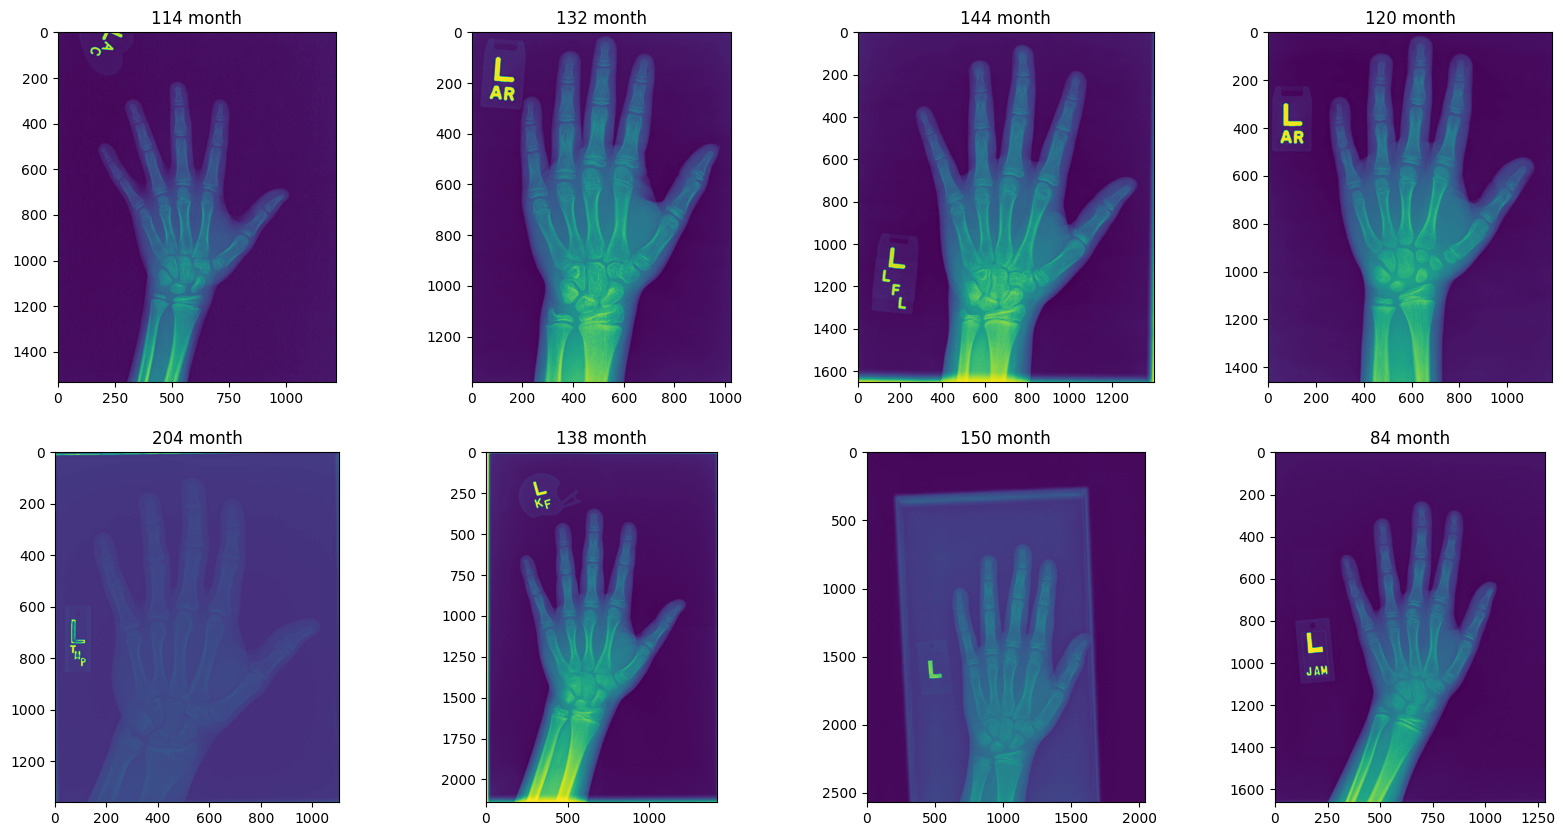

In [5]:
train_dir='dataset/RSNA_train/images'
test_dir= 'dataset/RSNA_test/images'
val_dir= 'dataset/RSNA_val/images'
sample = train_df.sample(n=8)
fig,axx = plt.subplots(2,4, figsize=(20,10))
for idd,boneage,place in zip(sample['ID'],sample['Boneage'],axx.flatten()):
    place.imshow(imread(f"{train_dir}/{idd}"))
    place.set_title(str(boneage)+' month')

In [6]:
core_dg = tf.keras.preprocessing.image.ImageDataGenerator()

train_dg = core_dg.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='ID',
    y_col='Boneage',
    target_size=(256,256),
    color_mode='grayscale',
    class_mode='raw',
    classes=None,
    batch_size=32,
    shuffle=True,
    save_format='png',
    interpolation='nearest',
)

Found 12611 validated image filenames.


In [7]:
test_dg = core_dg.flow_from_dataframe(
    test_df,
    x_col='ID',
    directory=test_dir,
    class_mode=None,
    )

Found 200 validated image filenames.


In [8]:
from keras.layers import Dense, MaxPooling2D, Input, Conv2D, SeparableConv2D, Dropout, BatchNormalization, Flatten, ReLU, Add, GlobalAveragePooling2D
from keras.metrics import MeanAbsoluteError
from keras.models import Model

CNN Model

In [8]:
input_shape=(256,256,1)
dropout_rate = 0.35

model_input= Input(shape=input_shape)

x = Conv2D(32,(3,3),activation='relu',padding='same')(model_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(64,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(dropout_rate)(x)

x = Conv2D(128,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(dropout_rate)(x)

x = Conv2D(256,(3,3),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(dropout_rate)(x)

x = Flatten()(x)
x = Dense(50,activation='relu')(x)
x = Dense(10,activation='relu')(x)
model_output = Dense(1,activation='linear')(x)


In [9]:
model = Model(model_input,model_output)

model.compile(loss='mae',optimizer='adam',metrics=[MeanAbsoluteError()])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256   

In [19]:
model.fit_generator(train_dg, epochs = 4)

C:\Users\prkna\AppData\Local\Temp\ipykernel_20988\796460892.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_dg, epochs = 4)


Epoch 1/4
395/395 [==============================] - 355s 898ms/step - loss: 23.5777 - mean_absolute_error: 23.5777
Epoch 2/4
395/395 [==============================] - 407s 1s/step - loss: 21.6529 - mean_absolute_error: 21.6529
Epoch 3/4
395/395 [==============================] - 427s 1s/step - loss: 20.3914 - mean_absolute_error: 20.3914
Epoch 4/4
395/395 [==============================] - 441s 1s/step - loss: 19.4395 - mean_absolute_error: 19.4395


In [20]:
model.save('chkpt_mae.h5')

In [11]:
model.load_weights('chkpt_mae.h5')

VGG Model

In [27]:
input_shape=(256,256,1)
dropout_rate = 0.35

model_input= Input(shape=input_shape)

x = Conv2D(64,(3,3),activation='relu',padding='same')(model_input)
x = Conv2D(64,(3,3),activation='relu',padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128,(3,3),activation='relu',padding='same')(x)
x = Conv2D(128,(3,3),activation='relu',padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(256,(3,3),activation='relu',padding='same')(x)
x = Conv2D(256,(3,3),activation='relu',padding='same')(x)
x = Conv2D(256,(3,3),activation='relu',padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(512,(3,3),activation='relu',padding='same')(x)
x = Conv2D(512,(3,3),activation='relu',padding='same')(x)
x = Conv2D(512,(3,3),activation='relu',padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(512,(3,3),activation='relu',padding='same')(x)
x = Conv2D(512,(3,3),activation='relu',padding='same')(x)
x = Conv2D(512,(3,3),activation='relu',padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(10,activation='relu')(x)
model_output = Dense(1,activation='linear')(x)


In [28]:
model_vgg = Model(model_input,model_output)

model_vgg.compile(loss='mae',optimizer='adam',metrics=[MeanAbsoluteError()])
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 64)      640       
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 128)     147584    
                                                           

In [29]:
model_vgg.fit_generator(train_dg,epochs=2)


C:\Users\prkna\AppData\Local\Temp\ipykernel_15700\2509111275.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_vgg.fit_generator(train_dg,epochs=2)


Epoch 1/2
395/395 [==============================] - 1148s 3s/step - loss: 51.0517 - mean_absolute_error: 51.0517
Epoch 2/2
395/395 [==============================] - 1105s 3s/step - loss: 33.1210 - mean_absolute_error: 33.1210


In [30]:
model_vgg.save('checkpoint_vgg.h5')

Xception Model

In [9]:
input_shape=(256,256,1)
dropout_rate = 0.35

model_input= Input(shape=input_shape)

def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPooling2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPooling2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPooling2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])

    return x

def middle_flow(tensor):
    
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
        
    return tensor

def exit_flow(tensor):
    
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPooling2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense (units = 1000, activation = 'softmax')(x)
    
    return x

input = Input(shape = (256,256,1))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

In [18]:
model_xce = Model (inputs=input, outputs=output)
model_xce.compile(loss='mae',optimizer='adam',metrics=[MeanAbsoluteError()])
model_xce.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  288         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

                                                                                                  
 separable_conv2d (SeparableCon  (None, 128, 128, 12  8768       ['re_lu_1[0][0]']                
 v2D)                           8)                                                                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 128, 128, 12  512        ['separable_conv2d[0][0]']       
 rmalization)                   8)                                                                
                                                                                                  
 re_lu_2 (ReLU)                 (None, 128, 128, 12  0           ['batch_normalization_2[0][0]']  
                                8)                                                                
                                                                                                  
 separable

In [19]:
model_xce.fit_generator(train_dg,epochs=2)

C:\Users\prkna\AppData\Local\Temp\ipykernel_3344\1453096537.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_xce.fit_generator(train_dg,epochs=2)


Epoch 1/2


ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/batch_normalization_6/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1899, in _run_once
      handle._run()
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\prkna\AppData\Local\Temp\ipykernel_3344\1453096537.py", line 1, in <module>
      model_xce.fit_generator(train_dg,epochs=2)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2507, in fit_generator
      return self.fit(
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_1/batch_normalization_6/FusedBatchNormV3'
OOM when allocating tensor with shape[32,256,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator gpu_async_0
	 [[{{node model_1/batch_normalization_6/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_11474]

In [ ]:
import cv2

Train data prediction

In [36]:
for _,i in train_df.head(10).iterrows():
    img = cv2.imread(f"{train_dir}/{i['ID']}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    img = cv2.resize(img, (256, 256))
    img = img.reshape((1, 256, 256, 1))
    y_true =i['Boneage']
    y_pred = round(model.predict(img,verbose=0)[0][0])
    print(f"true val:{y_true}\npred val:{y_pred}\ndiff val:{abs(y_true-y_pred)}")
    print('-'*30)

true val:180
pred val:164
diff val:16
------------------------------
true val:12
pred val:80
diff val:68
------------------------------
true val:94
pred val:104
diff val:10
------------------------------
true val:120
pred val:172
diff val:52
------------------------------
true val:82
pred val:74
diff val:8
------------------------------
true val:138
pred val:170
diff val:32
------------------------------
true val:150
pred val:135
diff val:15
------------------------------
true val:156
pred val:138
diff val:18
------------------------------
true val:36
pred val:39
diff val:3
------------------------------
true val:138
pred val:145
diff val:7
------------------------------


Validation data prediction

In [35]:
for _,i in val_df.head(10).iterrows():
    img = cv2.imread(f"{val_dir}/{i['ID']}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    img = cv2.resize(img, (256, 256))
    img = img.reshape((1, 256, 256, 1))
    y_true =i['Boneage']
    y_pred = round(model.predict(img,verbose=0)[0][0])
    print(f"true val:{y_true}\npred val:{y_pred}\ndiff val:{abs(y_true-y_pred)}")
    print('-'*30)

true val:30
pred val:87
diff val:57
------------------------------
true val:162
pred val:130
diff val:32
------------------------------
true val:18
pred val:75
diff val:57
------------------------------
true val:132
pred val:98
diff val:34
------------------------------
true val:57
pred val:113
diff val:56
------------------------------
true val:150
pred val:105
diff val:45
------------------------------
true val:24
pred val:71
diff val:47
------------------------------
true val:120
pred val:49
diff val:71
------------------------------
true val:16
pred val:85
diff val:69
------------------------------
true val:120
pred val:65
diff val:55
------------------------------
